In [12]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#### Reading Monthly Data

In [13]:
finalSeries = []

for i in range(2000,2017):
    filename = "../data/data"+str(i)
    for j in range(1,13):
        filename = filename + "month" + str(j) +".csv"
        data = pd.read_csv(filename, usecols=['NO2 Mean'])
        series = data['NO2 Mean'].tolist()
        if(len(series)<31 and len(series)!=0):
            while len(series)!=31:
                last = series[len(series)-1]
                series.append(last)
        if(len(series)!=0):
            series.append(j)
            seriesNP = np.asarray(series)
            finalSeries.append(seriesNP)
        filename = "../data/data"+str(i)

In [14]:
'''
for i in range(2000,2017):
    filename1 = "data/data"+str(i)
    for j in range(1,13):
        filename1 = filename1 + "month" + str(j) +".csv"
        data1 = pd.read_csv(filename1, usecols=['NO2 Mean'])
        series1 = data1['NO2 Mean'].tolist()
        if(len(series1)<31 and len(series1)!=0):
            while len(series1)!=31:
                last1 = series1[len(series1)-1]
                series1.append(last1)
        if(len(series1)!=0):
            series1.append(j)
            seriesNP1 = np.asarray(series1)
            finalSeries1.append(seriesNP1)
        filename1 = "data/data"+str(i)
'''

'\nfor i in range(2000,2017):\n    filename1 = "data/data"+str(i)\n    for j in range(1,13):\n        filename1 = filename1 + "month" + str(j) +".csv"\n        data1 = pd.read_csv(filename1, usecols=[\'NO2 Mean\'])\n        series1 = data1[\'NO2 Mean\'].tolist()\n        if(len(series1)<31 and len(series1)!=0):\n            while len(series1)!=31:\n                last1 = series1[len(series1)-1]\n                series1.append(last1)\n        if(len(series1)!=0):\n            series1.append(j)\n            seriesNP1 = np.asarray(series1)\n            finalSeries1.append(seriesNP1)\n        filename1 = "data/data"+str(i)\n'

#### Dynamic Time Warping & LB-Keogh

In [15]:
finalSeriesNP = np.asarray(finalSeries)
print(finalSeriesNP)

[[15.208333 18.5      31.521739 ... 28.083333 28.083333  1.      ]
 [27.       18.391304 20.       ... 19.695652 19.695652  2.      ]
 [20.166667 25.958333 22.       ... 14.333333 14.333333  3.      ]
 ...
 [19.633333 11.45      8.504167 ... 11.075     4.333333  1.      ]
 [ 2.058333 11.3      13.7875   ... 11.869565 11.869565  2.      ]
 [11.925    11.7625   12.275    ...  2.4625    9.25      3.      ]]


In [16]:
def DynamicTimeWarping(timeseries, centroid_timeseries, window):
    DTW_Dictionary={}
    
    for i in range(0,(len(timeseries)+1)):
        for j in range(0,(len(centroid_timeseries)+1)):
            if((i==0) & (j==0)):
                DTW_Dictionary[(i, j)] = float(0)
            else:
                DTW_Dictionary[(i, j)] = float('inf')    
       
    for item in range(len(timeseries)):
        low = (item-window) if (item-window)>=0 else 0
        high = (len(centroid_timeseries)) if ((item+window) >= (len(centroid_timeseries))) else (item+window)
        for second_item in range(low, high):    
            distance= (timeseries[item]-centroid_timeseries[second_item])**2
            DTW_Dictionary[(item+1), (second_item+1)] = distance + min(DTW_Dictionary[(item, second_item+1)],DTW_Dictionary[(item+1, second_item)], DTW_Dictionary[(item, second_item)])
    return np.sqrt(DTW_Dictionary[len(timeseries), len(centroid_timeseries)])

In [17]:
def LowerBoundKeogh(timeseries,centroid_timeseries,reach):
    lowerBoundSum=0
    for index, item in enumerate(timeseries):
        low = 0 if (index-reach)<0 else (index-reach)
        if len(centroid_timeseries[(low):(index+reach)])==0:
            break
        lowerBound = min(centroid_timeseries[(low):(index+reach)])
        upperBound = max(centroid_timeseries[(low):(index+reach)])
        
        if item>upperBound:
            lowerBoundSum = lowerBoundSum+(item-upperBound)**2
        elif item<lowerBound:
            lowerBoundSum = lowerBoundSum+(item-lowerBound)**2
    
    return np.sqrt(lowerBoundSum)

#### K-Means for clustering monthly data. Args - data, number of clusters, number of iterations, window

In [18]:
import random

def KMeans(data, numCluster, iterations, window):
    centroids = random.sample(list(data),numCluster)

    for n in range(iterations):
        print(n)
        clusterID = {}
        
        for index, item in enumerate(data):
            minDist = float('inf')
            closestCluster = None
            for centroidIndex, j in enumerate(centroids):
                if LowerBoundKeogh(item, j, 5) < minDist:
                    currentDist = DynamicTimeWarping(item, j, window)
                    if currentDist < minDist:
                        minDist = currentDist
                        closestCluster = centroidIndex
                       
            if closestCluster in clusterID:
                clusterID[closestCluster].append(index)
            else:
                clusterID[closestCluster]=[]

        for ID in clusterID:
            clusterSum = 0
            if ID is not None:
                for k in clusterID[ID]:
                    clusterSum = clusterSum + data[k]   
                centroids[ID] = [m/len(clusterID[ID]) for m in clusterSum if len(clusterID[ID])!=0]
    
    return centroids, clusterID

In [19]:
dataForKMeans = finalSeriesNP[:,:-1]

#### Output of clustering | Contains the months assigned to corresponding clusters
#### 1 - Jan, 2 - Feb, 3- Mar, 4 - Apr, 5 - May, 6 - Jun, 7 - July, 8 - Aug, 9 - Sept, 10 - Oct, 11 - Nov, 0 - Dec

0
1
2
3
4
5
6
7
8
9
{0: [1, 2, 3, 10, 11, 0, 2, 10, 11, 0, 1, 9, 10, 11, 0, 1, 8, 9, 10, 11, 0, 1, 11, 10, 11, 0, 1, 11, 10, 11, 0, 1, 11, 0, 11, 0, 11, 0], 1: [9, 1, 3, 4, 9, 2, 2, 7, 2, 9, 10, 0, 1, 2, 2, 3, 9, 10, 0, 1, 2, 9, 2, 10, 1, 10, 0, 1, 10, 11, 1, 9, 10, 1, 2, 9, 10, 11, 0, 10, 11, 0, 9, 9, 10], 2: [6, 7, 8, 5, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 9, 4, 5, 6, 7, 8, 3, 5, 3, 4, 5, 9, 2, 3, 9, 2, 9, 2, 8, 8, 1, 8, 9, 4, 7, 8, 10, 11, 8, 11], 3: [4, 6, 7, 8, 6, 7, 8, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 8, 3, 4, 5, 6, 7, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 1, 2, 3, 5, 6, 0, 1, 2, 3, 4, 5, 6, 7, 0]}


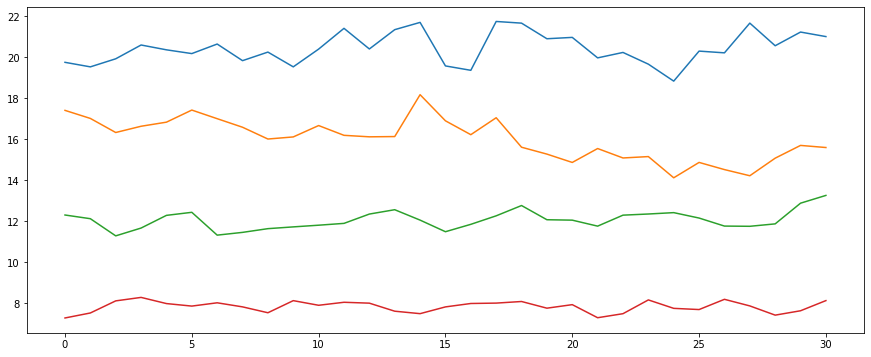

In [20]:
import matplotlib.pylab as plt

centroids, assignments = KMeans(dataForKMeans,4,10,4)

tempDict = {}
for k in assignments.keys():
    temp = []
    for i in assignments[k]:
        temp.append(i%12)
    tempDict[k] = temp
print(tempDict)
for i in centroids:
    
    plt.plot(i)

plt.show()

In [21]:
count = [0]*12
count_temp = [0]*12
count_max = 0
for i in range(0,12):
    for clust in assignments.keys():
        #print(clust)
        count_max = 0
        for element in assignments[clust]:
            if((element%12) == (i)):
                count_max = count_max + 1
        if(count_max > count_temp[i]):
            count_temp[i] = count_max
            count[i] = clust
print(count)

[0, 1, 1, 2, 2, 2, 3, 3, 2, 1, 1, 0]


#### Cleaning the clustering to know which month belongs to which cluters
#### Explanation - the list index indicates the months and the value represents the cluster number they belong to.